In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from imgaug import augmenters as iaa
sns.set(style="darkgrid", font_scale=1.0)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import io 
import pandas as pd

from tensorflow import keras
from keras.models import load_model
from keras.utils import plot_model
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import models

from keras import backend as K

In [ ]:
# logging and history

# get model summary string to be saved as text file
def get_model_summary(model):
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def logs(party, model, model_history, time_taken, test_acc):
  model_summary_string = get_model_summary(model)
  hist_df = pd.DataFrame(model_history.history)

  # write history to log text file
  title = r'drive/My Drive/' + str(party) + str('_log.txt')
  file = open(title, 'w')
  file.write("Model summary: \n" + str(model_summary_string))
  file.write("Number of Epochs: %d, Batch Size: %d" %(epochs, batch_size))
  file.write("\n History: \n" + str(hist_df))
  file.write(str("\nTime taken: %.4f," %((time_taken)) + ' Test accuracy: {:5.2f}%'.format(100 * test_acc)))
  file.close()
  print('logged for', party)

In [ ]:
# plot accuracy and loss graphs
def plot_graph(epochs_no, mode, party, train_model):
  if party is 'teacher':
    history = train_model.history
    history.keys()
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']   
     
    if mode is 'train':
      graph_ = 'Graph of train loss/accuracy vs number of epochs'
      y_axis = 'Loss/Accuracy'
      plt.plot(epochs_no, loss, 'ro', label='Training loss')
      plt.plot(epochs_no, acc, 'bo', label='Training accuracy')
      title = 'drive/My Drive/' + str(party) + 'model_train.png'
    elif mode is 'test':
      graph_ = 'Graph of test loss/accuracy vs number of epochs'
      y_axis = 'Loss/Accuracy'
      plt.plot(epochs_no, val_loss, 'r', label='Testing loss')
      plt.plot(epochs_no, val_acc, 'b', label='Testing accuracy')   
      title = 'drive/My Drive/' + str(party) + 'model_test.png' 

  elif party is 'student':
    history = train_model.history
    history.keys()
    test_acc = history['sparse_categorical_accuracy']
    train_loss = history['loss']
    test_loss = history['student_loss']

    plt.title('Graph of training/testing loss vs number of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')  
    if mode is 'loss':
      graph_ = 'Graph of train/test loss vs number of epochs'
      y_axis = 'Loss'
      plt.plot(epochs_no, train_loss, 'r', label='Training loss')
      plt.plot(epochs_no, test_loss, 'b', label='Testing loss')
      title = 'drive/My Drive/' + str(party) + 'test_loss.png'
    elif mode is 'accuracy':
      graph_ = 'Graph of test accuracy vs number of epochs'
      y_axis = 'Accuracy'
      plt.plot(epochs_no, test_acc, 'g', label='Testing accuracy')
      title = 'drive/My Drive/' + str(party) + 'test_acc.png' 
  plt.title(graph_)
  plt.xlabel('Epochs')
  plt.ylabel(y_axis) 
  plt.legend()
  plt.savefig(title)
  plt.show()

In [ ]:
img_width, img_height = 32, 32

# handle image format
if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

# download cifar data and split into train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# normalize data to range of [0,1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# to categorical for CategoricalCrossEntropy loss, else use SparseCategoricalCrossEntropy
# y_train = keras.utils.to_categorical(y_train)
# y_test = keras.utils.to_categorical(y_test)

# image augmentation
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Sometimes(
      0.5,
      iaa.GaussianBlur(sigma=(0, 0.5))
  )
], random_order=True)

# append augmented images to dataset to increase dataset size
aug_img = seq.augment_images(x_train)
x_train = np.append(x_train, aug_img, axis=0)
y_train = np.append(y_train, y_train, axis=0)

print("Dataset size:", x_train.shape, "Label size:", y_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
Dataset size: (100000, 32, 32, 3) Label size: (100000, 1)


In [ ]:
# Setup Teacher Model

# get VGG16 model
cifar_input = keras.layers.Input(shape=input_shape)
vgg_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=10)
vgg_model.trainable = True
# vgg_model.summary()

def teacher_model():
  # add BN to VGG model after pooling layers
  bn_vgg = keras.Sequential()
  bn_vgg.add(keras.layers.Input(shape=(32, 32, 3), name='main_inputs'))    
  for layer in vgg_model.layers:
    bn_vgg.add(layer)
    if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool']:
      bn_vgg.add(keras.layers.BatchNormalization())

  # add classifier layers
  teacher_model = keras.Sequential(name='teacher')
  teacher_model.add(bn_vgg)
  teacher_model.add(keras.layers.Flatten())
  teacher_model.add(keras.layers.Dense(4096, input_dim = 512, activation=tf.nn.relu))
  teacher_model.add(keras.layers.Dense(4096, activation=tf.nn.relu))
  teacher_model.add(keras.layers.Dense(10, name='logits'))
  teacher_model.add(keras.layers.Activation('softmax'))

  return teacher_model

teacher = teacher_model()
teacher.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 1, 512)         14718528  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
logits (Dense)               (None, 10)                40970     
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 33,642,058
Trainable params: 33,640,138
Non-tr

In [ ]:
# set hyperparameters
epochs = 50
batch_size = 64
lrate = 0.001
decay = lrate/epochs

lrr= tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5)

loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
adam1 = tf.keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9, nesterov=False) 
sgd1 = tf.keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False) 

In [ ]:
# compile teacher model and start training
teacher.compile(optimizer=adam, loss=loss_func, metrics=['accuracy'])

start_time = time.time()
teacher_train = teacher.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), steps_per_epoch=x_train.shape[0]//batch_size, batch_size=batch_size, callbacks=[lrr], shuffle=True)
time_taken = time.time() - start_time
print('Time taken for %d epochs: %.4f' % (epochs, time_taken))

# evaluate teacher model
test_loss, test_acc = teacher.evaluate(x_test, y_test)
print('Test accuracy: {:5.2f}%'.format(100 * test_acc))

1562/1562 [==============================] - 63s 40ms/step - loss: 1.7950 - accuracy: 0.6695 - val_loss: 1.6868 - val_accuracy: 0.7742
Time taken for 1 epochs: 64.1178
313/313 [==============================] - 3s 8ms/step - loss: 1.6868 - accuracy: 0.7742
Test accuracy: 77.42%


In [ ]:
# Save entire model to a HDF5 file
teacher.save('drive/My Drive/teacher_model.h5')
print('Model saved.')

# save model, logs and print graph
epochs_no = range(1, epochs + 1)

logs('teacher', teacher, teacher_train, time_taken, test_acc)
plot_graph(epochs_no, 'train', 'teacher', teacher_train)
plot_graph(epochs_no, 'test', 'teacher', teacher_train)

Model saved.


NameError: ignored

In [ ]:
# Setup Student Model
def student_model():
  student_model = keras.Sequential(name='student')
  student_model.add(keras.layers.Input(shape=(32, 32, 3), name='main_inputs')),
  student_model.add(keras.layers.ZeroPadding2D(padding=(1, 1))),
  student_model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')),
  student_model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=1)),
  student_model.add(keras.layers.BatchNormalization()),
  student_model.add(keras.layers.ZeroPadding2D(padding=(1, 1))),
  student_model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')),
  student_model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=1)),
  student_model.add(keras.layers.BatchNormalization()),
  student_model.add(keras.layers.ZeroPadding2D(padding=(1, 1))),
  student_model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')),
  student_model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=1)),
  student_model.add(keras.layers.BatchNormalization()),
  student_model.add(keras.layers.Flatten()),
  student_model.add(keras.layers.Dense(500)),
  student_model.add(keras.layers.Dense(10)),
  student_model.add(keras.layers.Activation('softmax')),

  return student_model

student = student_model()
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_9 (ZeroPaddin (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 32)        2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
zero_padding2d_10 (ZeroPaddi (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0   

In [ ]:
# distillation class taken from Keras documentation
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        teacher_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.teacher_loss_fn = teacher_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            teacher_loss = self.teacher_loss_fn(y, tf.nn.softmax(teacher_predictions / self.temperature, axis=1))
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            # loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
            loss = ((self.temperature^2) * self.alpha * distillation_loss) + ((1 - self.alpha) * student_loss)

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
# # restore teacher session to be distilled to student
teacher = keras.models.load_model('drive/My Drive/STDL/teacher_network/model.h5')

# compile distiller model and start training
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=adam,
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    teacher_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0,
    temperature=0,
)

# Distill teacher to student
start_time = time.time()
student_train = distiller.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
time_taken = time.time() - start_time
# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillation_loss: 0.0000e+00 - loss: nan
Epoch 2/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillation_loss: 0.0000e+00 - loss: nan
Epoch 3/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillation_loss: 0.0000e+00 - loss: nan
Epoch 4/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillation_loss: 0.0000e+00 - loss: nan
Epoch 5/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillation_loss: 0.0000e+00 - loss: nan
Epoch 6/50
1563/1563 [==============================] - 54s 35ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan - distillati

0.10000000149011612

Model saved.
313/313 [==============================] - 1s 5ms/step - sparse_categorical_accuracy: 0.1000 - student_loss: nan
logged for student


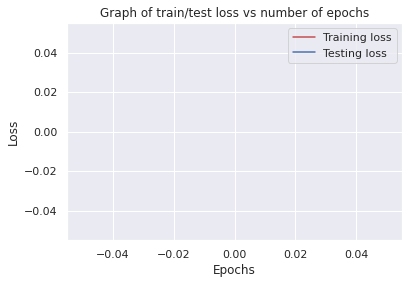

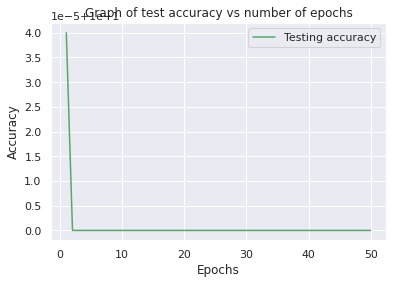

In [ ]:
# Save entire model to a HDF5 file
# distiller.save('drive/My Drive/student_model.h5')
print('Model saved.')

# save model, logs and print graph
epochs_no = range(1, epochs + 1)

logs('student', student, student_train, time_taken, distiller.evaluate(x_test, y_test))
plot_graph(epochs_no, 'loss', 'student', student_train)
plot_graph(epochs_no, 'accuracy', 'student', student_train)